In [9]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import glob
import cv2
from sklearn.preprocessing import LabelEncoder
import json

In [2]:
def eis_dataframe_from_csv(csv_path) -> pd.DataFrame:
    """ Reads a CSV file of EIS data into a pandas dataframe
    Each row is an impedance meausurement

    Args:
        csv_df_path (File-Like-Object): path to file of, or buffer of, EIS data in CSV format

    Return
    ------
    df : pandas.DataFrame
        A dataframe with two to four columns - each row represents an EIS spectrum
            - id: unique identifier for each measurement
            - freq: frequency of measurement
            - Z: short for impedance, column of imaginary-number numpy arrays
            - zimag: imaginary part of impedance
            - Circuit: Equivalent Circuit Model labels assigned to the spectra (Optional)
            - Parameters: Parameters of the Equivalent Circuit Models (Optional) 
    """
    df = pd.read_csv(csv_path, index_col=0)

    def real2array(arraystr: str):
        return np.array([float(c.strip("[]")) for c in arraystr.split(", ")])

    def comp2array(arraystr: str):
        return np.array(
            [complex(c.strip("[]").replace(" ", "")) for c in arraystr.split(", ")]
        )

    if "freq" in df.columns:
        df["freq"] = df["freq"].apply(real2array)
    if "Z" in df.columns:
        df["Z"] = df["Z"].apply(comp2array)

    return df

def process_batch_element_f(interpolated_basis):
    return interpolated_basis

def process_batch_element_zreal(freq, Z, interpolated_basis):
    """Interpolates the real part of the impedance onto a common frequency basis"""
    x = np.real(Z)
    f = interp1d(freq, x, fill_value="extrapolate")  # extrapolate to prevent errors
    return f(interpolated_basis)

def process_batch_element_zimag(freq, Z, interpolated_basis):
    """Interpolates the imaginary part of the impedance onto a common frequency basis"""
    x = np.imag(Z)
    f = interp1d(freq, x, fill_value="extrapolate")  # extrapolate to prevent errors
    return f(interpolated_basis)

def preprocess_data(file_name):
    """Preprocesses the data from the CSV filename into a dataframe"""
    ## Load Training Data
    df = eis_dataframe_from_csv(file_name)

    interpolated_basis = np.geomspace(10, 1e5, num=70)

    df["f"] = df.apply(lambda x: process_batch_element_f(interpolated_basis), axis=1)
    df["zreal"] = df.apply(
        lambda x: process_batch_element_zreal(x.freq, x.Z, interpolated_basis), axis=1
    )
    df["zimag"] = df.apply(
        lambda x: process_batch_element_zimag(x.freq, x.Z, interpolated_basis), axis=1
    )
    return df

In [3]:
d_path = './data/'
df = preprocess_data(d_path + "train_data_newspl.csv")
df_test = preprocess_data(d_path + "test_data_newspl.csv")

In [4]:
real = df.at[0, 'zreal']
imag = df.at[0, 'zimag']
frequence = df.at[0, 'f']
real_minmaxed = (real-np.min(real))/(np.max(real)-np.min(real))
imag_minmaxed = (imag-np.min(imag))/(np.max(imag)-np.min(imag))

In [5]:
def plot_colourline(x,y,c):
    
    c = cm.jet((c-np.min(c))/(np.max(c)-np.min(c)))
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
        plt.axis("off")
    return

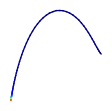

In [6]:
fig = plt.figure(figsize = (2, 2), dpi=64, frameon=False)
plot_colourline(real_minmaxed, -imag_minmaxed, frequence)

In [7]:
def plot_eis_nyquist_individual(df: pd.DataFrame, name='train'):
    """Plot the nyquist diagram for all eis data in the dataframe"""
    
    def plot_colourline(x,y,c):
        fig = plt.figure(figsize = (4, 4), dpi=64, frameon=False)
        c = cm.jet((c-np.min(c))/(np.max(c)-np.min(c)))
        ax = plt.gca()
        for i in np.arange(len(x)-1):
            ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
            plt.axis("off")
        return

    nb_spectra = len(df)
    # nb_spectra = 1 
    for i in range(nb_spectra):
        real = df.at[i, 'zreal']
        imag = df.at[i, 'zimag']
        frequence = df.at[i, 'f']
        real_minmaxed = (real-np.min(real))/(np.max(real)-np.min(real))
        imag_minmaxed = (imag-np.min(imag))/(np.max(imag)-np.min(imag))
        plot_colourline(real_minmaxed, -imag_minmaxed, frequence)
        try:
            plt.savefig(f'./images2/{name}/{df["Circuit"][i]}/{i}.png', dpi=64, bbox_inches='tight', pad_inches=0)
        except:
            os.makedirs(f'./images2/{name}/{df["Circuit"][i]}')
            plt.savefig(f'./images2/{name}/{df["Circuit"][i]}/{i}.png', dpi=64, bbox_inches='tight', pad_inches=0)
        plt.close()
        if np.mod(i, 100) == 0:
            print(f'Processed {i} spectra out of {nb_spectra}')
        

In [8]:
plot_eis_nyquist_individual(df, name='train')
plot_eis_nyquist_individual(df_test, name='test')

Processed 0 spectra out of 7462
Processed 100 spectra out of 7462
Processed 200 spectra out of 7462
Processed 300 spectra out of 7462
Processed 400 spectra out of 7462
Processed 500 spectra out of 7462


c:\Users\EQ01\Documents\Programas\CONDA\Installation\envs\gpu\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Processed 600 spectra out of 7462
Processed 700 spectra out of 7462
Processed 800 spectra out of 7462
Processed 900 spectra out of 7462
Processed 1000 spectra out of 7462
Processed 1100 spectra out of 7462
Processed 1200 spectra out of 7462
Processed 1300 spectra out of 7462
Processed 1400 spectra out of 7462
Processed 1500 spectra out of 7462
Processed 1600 spectra out of 7462
Processed 1700 spectra out of 7462
Processed 1800 spectra out of 7462
Processed 1900 spectra out of 7462
Processed 2000 spectra out of 7462
Processed 2100 spectra out of 7462
Processed 2200 spectra out of 7462
Processed 2300 spectra out of 7462
Processed 2400 spectra out of 7462
Processed 2500 spectra out of 7462
Processed 2600 spectra out of 7462
Processed 2700 spectra out of 7462
Processed 2800 spectra out of 7462
Processed 2900 spectra out of 7462
Processed 3000 spectra out of 7462
Processed 3100 spectra out of 7462
Processed 3200 spectra out of 7462
Processed 3300 spectra out of 7462
Processed 3400 spectra o